Necessary imports

In [71]:
%pip install pandas
%pip install plotly
%pip install matplotlib
%pip install scipy

from scipy import stats
import pandas as pd
import plotly.express as px


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


# Carregamento de dados

A partir do site que pegamos o arquivo (http://dados.recife.pe.gov.br/pt_BR/dataset/servico-de-atendimento-movel-de-urgencia-samu-2022/resource/7c005351-2d14-46cf-b2f0-6622a5553b30), os tipos dos dados são:

data: timestamp

hora_minuto: text municipio: text

bairro: text

endereco: text

origem_chamado: text

tipo: text

subtipo: text

sexo: text

idade: numeric

motivo_finalizacao: text

motivo_desfecho: text

In [72]:
dtypes = {
    "hora_minuto":  str,
    "municipio": "category",
    "bairro": "category",
    "endereco": "category",
    "origem_chamado": "category",
    "tipo": "category",
    "subtipo": "category",
    "sexo": "category",
    "idade": float,
    "motivo_finalizacao": "category",
    "motivo_desfecho": "category",
}

columns_to_datetime = ["data"]

raw_df = pd.read_csv("./datasets/ocorrencias2022.csv", sep=';', dtype=dtypes, parse_dates=columns_to_datetime)
raw_df.head()

,data,hora_minuto,municipio,bairro,endereco,origem_chamado,tipo,subtipo,sexo,idade,motivo_finalizacao,motivo_desfecho
0,2022-01-01,00:02:19,RECIFE,JARDIM SAO PAULO,R LEANDRO BARRETO,RESIDENCIAL,RESPIRATORIA,CASO SUSPEITO COVID-19,FEMININO,81.0,NaN,PACIENTE RECUSA SER REMOVIDO
1,2022-01-01,00:03:00,RECIFE,MADALENA,R ALTINHO,RESIDENCIAL,CAUSAS EXTERNAS,QUEDA DA PROPRIA ALTURA,FEMININO,81.0,NaN,DESISTÊNCIA DA SOLICITAÇÃO
2,2022-01-01,00:09:38,MACAPARANA,CENTRO,R POSSIDONIO JULIAO DA SILVA,VIA PÚBLICA,CAUSAS EXTERNAS,OUTROS,MASCULINO,0.0,REGULAÇÃO POR TELEFONE,SEM DESFECHO
3,2022-01-01,00:10:02,VITORIA DE SANTO ANTAO,CENTRO,RUA JOSE COSTA N 93 BAIRRO DA,RESIDENCIAL,GERAIS/OUTROS,OUTROS,FEMININO,NaN,DESISTÊNCIA DA SOLICITAÇÃO,SEM DESFECHO
4,2022-01-01,00:12:16,PALMARES,PALMARES CENTRO,RUA DOUTOR COSTA MAIA,RESIDENCIAL,GERAIS/OUTROS,OUTROS,MASCULINO,84.0,NaN,OCORRÊNCIA CONCLUÍDA COM ÊXITO


# Considerações iniciais sobre o dataset

O dataset descreve ligações para o Serviço de Atendimento Móvel de Urgência (SAMU), realizados no ano de 2022.
Possui informações que identificam:

O local e hora onde uma ocorrência foi registrada;

Sexo e idade que identificam o indivíduo responsável pelo chamado;

Municipio, Bairro e Endereço do chamado;

Tipo e Subtipo do chamado;

E por fim, motivos da finalização e desfecho do chamado.

In [73]:
raw_df.describe()

,idade
count,93764.000000
mean,47.013886
std,25.460475
min,0.000000
25%,28.000000
50%,47.000000
75%,67.000000
max,747.000000


In [74]:
raw_df.dtypes

data                  datetime64[ns]
hora_minuto                   object
municipio                   category
bairro                      category
endereco                    category
origem_chamado              category
tipo                        category
subtipo                     category
sexo                        category
idade                        float64
motivo_finalizacao          category
motivo_desfecho             category
dtype: object

In [75]:
raw_df.isna().sum()

data                      0
hora_minuto               0
municipio                 3
bairro                    4
endereco               1914
origem_chamado            0
tipo                      0
subtipo                  17
sexo                   1399
idade                   926
motivo_finalizacao    60456
motivo_desfecho           0
dtype: int64

# Tratando dados vazios

Já que mais da metade do dataset está com a coluna "motivo_finalizacao" vazia, será impraticável utilizar essa coluna na nossa análise, portanto removeremos ela.

para o restante das colunas, nós removeremos as instâncias que contém alguma coluna vazia, com exceção da coluna de endereço, já que ela não vai ser tão útil para a análise que queremos.

A remoção dessas instâncias não vão fazer muita diferença já que a quantidade das linhas removidas são ínfimas, (menos de 5%), em comparação à quantidade total de dados do dataset.

In [76]:
raw_df = raw_df.drop("motivo_finalizacao", axis=1)
raw_df = raw_df.dropna(subset=["municipio", "bairro", "subtipo", "sexo", "idade"])
raw_df.isna().sum()

data                  0
hora_minuto           0
municipio             0
bairro                0
endereco           1838
origem_chamado        0
tipo                  0
subtipo               0
sexo                  0
idade                 0
motivo_desfecho       0
dtype: int64

In [77]:
raw_df["idade"].describe()

count    92459.000000
mean        47.110211
std         25.315927
min          0.000000
25%         28.000000
50%         47.000000
75%         67.000000
max        747.000000
Name: idade, dtype: float64

ter a idade máxima de 747 é impossível, uma passada no google diz que há pessoas com certificados de nascimento entre 115 anos até 121 anos, portanto nós escolhemos definir uma idade máxima de 120 anos para deixar mais fácil de discretizar a idade em uma série de 6 categorias.

In [78]:
def older_than_120(age: int):
  if age >= 120:
    return 120
  return age

raw_df["idade"] = raw_df["idade"].apply(lambda x : older_than_120(x))
raw_df["idade"].describe()

count    92459.000000
mean        47.088656
std         25.079854
min          0.000000
25%         28.000000
50%         47.000000
75%         67.000000
max        120.000000
Name: idade, dtype: float64

In [79]:
raw_df["faixa_etaria"] = pd.cut(raw_df["idade"], 6)
raw_df["faixa_etaria"]

0        (80.0, 100.0]
1        (80.0, 100.0]
2        (-0.12, 20.0]
4        (80.0, 100.0]
5        (-0.12, 20.0]
             ...      
94685     (40.0, 60.0]
94686     (60.0, 80.0]
94687    (-0.12, 20.0]
94688     (40.0, 60.0]
94689    (80.0, 100.0]
Name: faixa_etaria, Length: 92459, dtype: category
Categories (6, interval[float64, right]): [(-0.12, 20.0] < (20.0, 40.0] < (40.0, 60.0] < (60.0, 80.0] < (80.0, 100.0] < (100.0, 120.0]]

<AxesSubplot:>

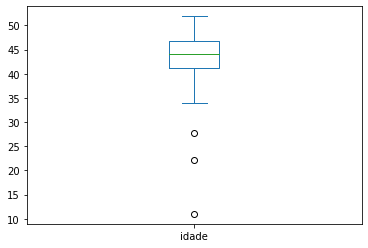

In [80]:
idade_ascending = raw_df.groupby("municipio")["idade"].mean().sort_values(ascending=True)
idade_ascending.plot.box()

Esse box plot indica que o dataset pode conter alguns outliers em questão da idade, mas nós decidimos não tentar tratar pessoas com idades muito diferentes da média. O motivo disso é que não há como delimitar um limite mínimo ou máximo de idade, para que a pessoa seja atendida pelo SAMU, um bebê de 0 anos pode ser atendido e uma pessoa de 120 anos pode ser atendida.

# Testes de hipótese

Para começar os testes nós temos primeiro que determinar se 

1. Ocorrências que foram determinadas como "TROTE" são mais prováveis de serem atribuídas a homens.
2. Dentre os municípios com maiores frequências de ocorrências, as que resultam em óbitos possuem frequência por tipo de ocorrência similar independente do município.
3. A distribuição de Faixa Etária para os tipos de ocorrência "CARDIOLOGICA" e "RESPIRATORIA" são semelhantes. 
4. As frequências de tipos de ocorrência são semelhantes para cada um dos 5 Municipios com maior número de ocorrências em Recife.

Como o dataset não possui uma distribuição normal, utilizaremos, geralmente, os tipos de dados "Rank" e "Score".

1. Ocorrências que foram determinadas como "TROTE" são mais prováveis de serem atribuídas a homens.



In [81]:
trotes_df = raw_df[raw_df['motivo_desfecho'] == 'TROTE']
trotes_table = trotes_df.groupby(['municipio', 'sexo'])['data'].agg(['count']).reset_index()
trotes_table

,municipio,sexo,count
0,ABREU E LIMA,FEMININO,1
1,ABREU E LIMA,MASCULINO,0
2,AGUA PRETA,FEMININO,0
3,AGUA PRETA,MASCULINO,1
4,ALIANCA,FEMININO,1
...,...,...,...
139,VICENCIA,MASCULINO,0
140,VITORIA DE SANTO ANTAO,FEMININO,1
141,VITORIA DE SANTO ANTAO,MASCULINO,5
142,XEXEU,FEMININO,0


<AxesSubplot:ylabel='Frequency'>

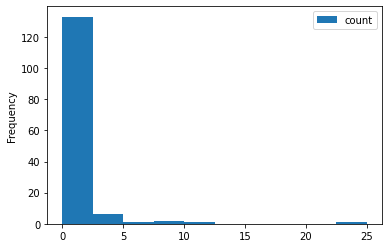

In [82]:
trotes_table.plot.hist()

Com esse teste de hipótese, gostaríamos de testar a teoria de que homens cometem mais trotes. Como os indivíduos descritos pelo dataset não são pareados, e vendo que a distribuição não é uma distribuição normal, utilizaremos a técnica de teste "Mann-Whitney".

Hipótese Nula a ser testada: Não há diferença significativa entre os números de trotes, separados por municípios, praticados por aqueles que identificaram-se como do sexo masculino e daqueles que identificaram-se como do sexo feminino.

In [83]:
trotes_femininos_por_municipio = trotes_table[trotes_table['sexo'] == 'FEMININO']
trotes_masculinos_por_municipio = trotes_table[trotes_table['sexo'] == 'MASCULINO']

# Taking the list of frequencies
trotes_femininos_por_municipio = trotes_femininos_por_municipio['count'].to_list()
trotes_masculinos_por_municipio = trotes_masculinos_por_municipio['count'].to_list()

len(trotes_femininos_por_municipio) == len(trotes_masculinos_por_municipio)

True

In [84]:

from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(trotes_femininos_por_municipio, trotes_masculinos_por_municipio)
print('Statistics=%.2f, p=%.2f' % (stat, p_value))

alpha = 0.05
if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Statistics=2546.00, p=0.82
Do not Reject Null Hypothesis (No significant difference between two samples)


Como não podemos rejeitar a hipótese nula, podemos afirmar que desprovamos nossa hipótese:

A frequência de trotes praticados por homens e mulheres, agrupados por municípios, é, na verdade, bastante semelhante.

2. Dentre os municípios com maiores frequências de ocorrências, as que resultam em óbitos possuem frequência por tipo de ocorrência similar independente do município.

Hipótese Nula a ser testada: Não há diferença significativa entre a frequência de ocorrências que resultam em mortes, agrupadas por tipo de ocorrência, de cada municipio.

In [85]:
raw_df['motivo_desfecho'].unique().to_list()

['PACIENTE RECUSA SER REMOVIDO',
 'DESISTÊNCIA DA SOLICITAÇÃO',
 'SEM DESFECHO',
 'OCORRÊNCIA CONCLUÍDA COM ÊXITO',
 'REMOVIDO ANTES DO ATENDIMENTO POR PARTICULARES',
 'NÃO HÁ PACIENTE NO ENDEREÇO',
 'CASA FECHADA / NINGUÉM ATENDE AO CHAMADO',
 'REMOVIDO PELOS BOMBEIROS/CIODS',
 'ACOMPANHANTE RECUSA REMOÇÃO',
 'PACIENTE JÉ ENCONTRADO EM ÓBITO',
 'ÓBITO DURANTE O ATENDIMENTO',
 'PACIENTE NÃO NECESSITA DE REMOÇÃO',
 'TROTE',
 'SOLICITAÇÃO DUPLICADA',
 'PACIENTE SEM CONDIÇÕES CLÍNICAS DE REMOÇÃO HOSPITALAR']

In [86]:
highest_frequencies = raw_df.groupby(['municipio'])['data'].agg(['count']).reset_index()
highest_frequencies = highest_frequencies[highest_frequencies['count'] >= 500]

highest_frequencies_municipios = highest_frequencies['municipio'].to_list()
highest_frequencies_municipios

['ABREU E LIMA',
 'CABO DE SANTO AGOSTINHO',
 'CAMARAGIBE',
 'CARPINA',
 'ESCADA',
 'GOIANA',
 'IGARASSU',
 'ILHA DE ITAMARACA',
 'IPOJUCA',
 'JABOATAO DOS GUARARAPES',
 'LIMOEIRO',
 'MORENO',
 'NAZARE DA MATA',
 'OLINDA',
 'PALMARES',
 'PAULISTA',
 'POMBOS',
 'RECIFE',
 'SAO LOURENCO DA MATA',
 'SURUBIM',
 'TIMBAUBA',
 'VITORIA DE SANTO ANTAO']

In [87]:
motivo_obito_1 = 'PACIENTE JÉ ENCONTRADO EM ÓBITO'
motivo_obito_2 = 'ÓBITO DURANTE O ATENDIMENTO'

def check_obito(motivo: str):
    if motivo == motivo_obito_1 or motivo == motivo_obito_2:
        return True
    return False

def check_municipio(municipio: str):
    if municipio in highest_frequencies_municipios:
        return True
    return False

obitos_df = raw_df[raw_df['motivo_desfecho'].apply(lambda x : check_obito(x))]

In [88]:
obitos_table = obitos_df.groupby(['municipio', 'tipo'])['data'].agg(['count']).reset_index()
obitos_table = obitos_table[obitos_table['municipio'].apply(lambda x : check_municipio(x))]
obitos_table

,municipio,tipo,count
0,ABREU E LIMA,ASSINTOMATICO,0
1,ABREU E LIMA,CARDIOLOGICA,10
2,ABREU E LIMA,CAUSAS EXTERNAS,5
3,ABREU E LIMA,DROGAS,0
4,ABREU E LIMA,ENDOCRINOLOGICA,2
...,...,...,...
1273,VITORIA DE SANTO ANTAO,OFTALMOLOGICA,0
1274,VITORIA DE SANTO ANTAO,ONCOLOGICA,0
1275,VITORIA DE SANTO ANTAO,OTORRINOLARINGOLOGICA,0
1276,VITORIA DE SANTO ANTAO,PSIQUIATRICA,0


<AxesSubplot:ylabel='Frequency'>

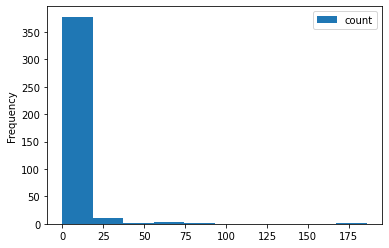

In [89]:
obitos_table.plot.hist()

claramente a distribuição não é uma normal, como queremos testar vários grupos, n >= 3, usaremos kruskal.

In [90]:
municipios_frequency = []
for municipio in highest_frequencies_municipios:
    aux_table = obitos_table[obitos_table['municipio'] == municipio]
    municipios_frequency.append(aux_table['count'].to_list())

In [91]:
municipios_frequency

[[0, 10, 5, 0, 2, 0, 16, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 3],
 [0, 13, 17, 0, 0, 1, 15, 0, 0, 0, 5, 0, 0, 0, 2, 0, 0, 4],
 [0, 14, 7, 0, 0, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6],
 [0, 8, 2, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3],
 [0, 3, 3, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 7, 7, 0, 0, 0, 8, 0, 0, 0, 4, 0, 0, 0, 1, 0, 1, 7],
 [0, 11, 6, 0, 0, 0, 12, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 6],
 [0, 4, 2, 1, 0, 0, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
 [0, 8, 5, 0, 0, 2, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 4],
 [0, 63, 34, 2, 2, 0, 65, 0, 0, 0, 17, 0, 0, 0, 8, 0, 0, 29],
 [0, 11, 4, 0, 0, 1, 9, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3],
 [0, 4, 2, 0, 1, 1, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3],
 [0, 3, 3, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2],
 [0, 50, 12, 2, 2, 1, 36, 0, 0, 0, 9, 0, 0, 0, 2, 0, 1, 19],
 [0, 10, 9, 0, 1, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2],
 [0, 27, 25, 0, 3, 1, 36, 0, 0, 1, 14, 0, 0, 0, 0, 0, 0, 20],
 [0, 3, 5, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 18

In [92]:
from scipy import stats

stat, p_value = stats.kruskal(*municipios_frequency)
print('Statistics=%.2f, p=%.20f' % (stat, p_value))

alpha = 0.05

if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between samples)')

Statistics=18.81, p=0.59731203519323572415
Do not Reject Null Hypothesis (No significant difference between samples)


Como não podemos rejeitar a hipótese nula, podemos afirmar que aprovamos nossa hipótese:

Dentre os municípios com maiores frequências de ocorrências, as que resultam em óbitos possuem frequência por tipo de ocorrência similar independente do município.

3. A distribuição de Faixa Etária para os tipos de ocorrência "CARDIOLOGICA" e "RESPIRATORIA" são semelhantes.

Hipotése nula: A distribuição de Faixa Etária para os tipos de ocorrência "CARDIOLOGICA" e "RESPIRATORIA" são semelhantes.

<AxesSubplot:ylabel='Frequency'>

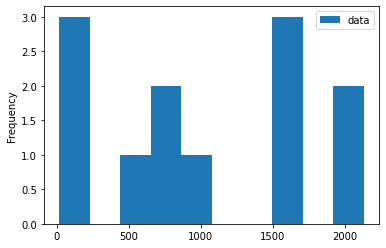

In [103]:
faixa_etaria_df = raw_df.groupby(["faixa_etaria", "tipo"])["data"].agg("count").reset_index()
faixa_etaria_df = faixa_etaria_df[faixa_etaria_df["tipo"].isin(["CARDIOLOGICA", "RESPIRATORIA"])]
faixa_etaria_df.plot.hist()

Isso aqui talvez pode ser considerado distribuição normal, então vamos usar o teste de shapiro-wilk para testar essa possibilidade.

In [105]:
stats.shapiro(faixa_etaria_df["data"])

ShapiroResult(statistic=0.9252513647079468, pvalue=0.33248022198677063)

O pvalue deu maior que 0.05, portanto pelo teste de shapiro, isso pode ser considerado uma distribuição normal. Como ela é uma distribuição normal e não pareada, nós utilizaremos o unpaired t-test. 

In [108]:
from scipy.stats import ttest_ind

stats, pvalue = ttest_ind(faixa_etaria_df[faixa_etaria_df["tipo"] == "CARDIOLOGICA"]["data"], faixa_etaria_df[faixa_etaria_df["tipo"] == "RESPIRATORIA"]["data"])


alpha = 0.05

if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between samples)')


Do not Reject Null Hypothesis (No significant difference between samples)


Como o resultado não conseguiu rejeitar a hipótese nula, a nossa hipótese inicial está correta.

4. As frequências de tipos de ocorrência são semelhantes para cada um dos 5 Municipios com maior número de ocorrências em Recife.

Hipotése nula: As frequências de tipos de ocorrência são semelhantes para cada um dos 5 Municipios com maior número de ocorrências em Recife.

In [122]:
highest_5 = raw_df.groupby(['municipio'])['data'].agg(['count']).reset_index()
highest_5 = highest_5.sort_values(by="count", ascending=False)
highest_5 = highest_5[0:5]
highest_5_names = highest_5["municipio"].values.to_list()
highest_5_names

['RECIFE',
 'JABOATAO DOS GUARARAPES',
 'OLINDA',
 'PAULISTA',
 'CABO DE SANTO AGOSTINHO']

In [127]:
frequencia_ocorrencia = raw_df.groupby(["municipio", "tipo"])["data"].agg(["count"]).reset_index()
frequencia_ocorrencia = frequencia_ocorrencia[frequencia_ocorrencia["municipio"].isin(highest_5_names)]
frequencia_ocorrencia

,municipio,tipo,count
162,CABO DE SANTO AGOSTINHO,ASSINTOMATICO,1
163,CABO DE SANTO AGOSTINHO,CARDIOLOGICA,151
164,CABO DE SANTO AGOSTINHO,CAUSAS EXTERNAS,763
165,CABO DE SANTO AGOSTINHO,DROGAS,26
166,CABO DE SANTO AGOSTINHO,ENDOCRINOLOGICA,35
...,...,...,...
1003,RECIFE,OFTALMOLOGICA,9
1004,RECIFE,ONCOLOGICA,286
1005,RECIFE,OTORRINOLARINGOLOGICA,45
1006,RECIFE,PSIQUIATRICA,3009


<AxesSubplot:ylabel='Frequency'>

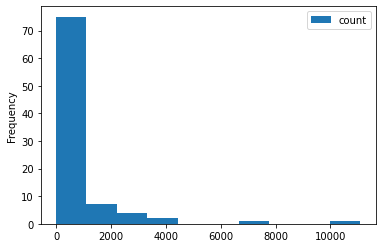

In [128]:
frequencia_ocorrencia.plot.hist()


Não há chance de ser uma distribuição normal. Como estamos testando mais de 2 grupos (municípios), usaremos o teste de kruskal.

In [126]:
frequencia_ocorrencia_list = []

for munic in highest_5_names:
    aux = frequencia_ocorrencia[frequencia_ocorrencia["municipio"] == munic]
    frequencia_ocorrencia.append(aux)

In [129]:
from scipy import stats

stat, p_value = stats.kruskal(*frequencia_ocorrencia)
print('Statistics=%.2f, p=%.20f' % (stat, p_value))

alpha = 0.05

if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between samples)')


Statistics=2.00, p=0.36787944117144244505
Do not Reject Null Hypothesis (No significant difference between samples)


Como a hipótese nula não é rejeitada, podemos afirmar que a nossa hipótese inicial é verdadeira.